# Comparing Validation Accuracy of Voxforge/Youtube, Librivox, Guru Dataset
Is evaluation on the Librivox dataset a way to measure the robustness for the Guru Dataset?

**Conclusion:** Librivox accuracy more or less correlates with guru accuracy. Thus it can be used as replacement Validation data in order to optimize robustness

In [1]:
from comet_ml import Experiment
import keras
from keras import models, layers
from keras.optimizers import RMSprop
import numpy as np
from kapre.time_frequency import Melspectrogram
from kapre.augmentation import AdditiveNoise
from kapre.utils import Normalization2D
from keras import regularizers

import sys
import os
sys.path.append('../')
from utils import DataFeed

# to avoid different initizialization of weights
np.random.seed(42)

Using TensorFlow backend.


## Helper Function

In [7]:
# Let's on validate on mutliple datasets
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        SourceSource: https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            
            validation_data, validation_targets, validation_set_name = validation_set

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          batch_size=self.batch_size)
            
            print(f"{validation_set_name}: {model.metrics_names[0]} = {results[0]},  {model.metrics_names[1]} = {results[1]}")
            for i, result in enumerate(results):
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i-1]
                self.history.setdefault(valuename, []).append(result)

## Data

In [3]:
data_path = '../preprocessing/preprocessed_data'

train_data, train_labels = DataFeed.Dataset.create(data_path, ['train/voxforge', 'train/youtube'], num=-1, use_premade=True)
val_data, val_labels = DataFeed.Dataset.create(data_path, ['test/guru'], num=-1, shuffle=True)
val_data2, val_labels2 = DataFeed.Dataset.create(data_path, ['val/voxforge', 'val/youtube'], num=-1, shuffle=True)

In [11]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=5),
             #keras.callbacks.ModelCheckpoint('berlin_net_decibel_static.h5', monitor='val_loss', save_best_only=True),
             AdditionalValidationSets([(val_data2, val_labels2, 'librivox')], verbose=0)]

## Model

In [21]:
model = models.Sequential()
model.add(Melspectrogram(n_dft=512, input_shape=(1, 5 * 16000,),
                         padding='same', sr=16000, n_mels=28,
                         fmin=0, fmax=8000, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False))
model.add(Normalization2D(str_axis='freq'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(1048, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [22]:
model.compile(optimizer=RMSprop(),
              metrics=['accuracy'],
              loss='categorical_crossentropy')

In [23]:
history = model.fit(x=train_data,
                    y=train_labels,
                    batch_size=32, 
                    epochs=8,
                    validation_data=(val_data[:-1], val_labels[:-1]), 
                    shuffle=True,
                    callbacks=callbacks)

Train on 50000 samples, validate on 69 samples
Epoch 1/8
50000/50000 [==============================] - 38s 757us/step - loss: 0.7359 - acc: 0.6698 - val_loss: 0.7593 - val_acc: 0.7101
librivox: loss = 0.42673072686195374,  acc = 0.8285
Epoch 2/8
50000/50000 [==============================] - 38s 752us/step - loss: 0.4533 - acc: 0.8233 - val_loss: 1.5381 - val_acc: 0.5072
librivox: loss = 0.6103239430427552,  acc = 0.7388
Epoch 3/8
50000/50000 [==============================] - 38s 754us/step - loss: 0.3829 - acc: 0.8557 - val_loss: 1.3179 - val_acc: 0.7101
librivox: loss = 0.38340188789367674,  acc = 0.8618
Epoch 4/8
50000/50000 [==============================] - 38s 756us/step - loss: 0.3471 - acc: 0.8722 - val_loss: 1.1172 - val_acc: 0.7101
librivox: loss = 0.31274933001995087,  acc = 0.8809
Epoch 5/8
50000/50000 [==============================] - 38s 757us/step - loss: 0.3392 - acc: 0.8778 - val_loss: 0.6727 - val_acc: 0.7391
librivox: loss = 0.29405566680431366,  acc = 0.8855
Epoc

## Plotting

In [24]:
import matplotlib.pyplot as plt

# Plot inside the jupyter notebook
%matplotlib inline

In [37]:
train_acc = history.history['acc']
train_loss = history.history['loss']
guru_acc = history.history['val_acc']
guru_loss = history.history['val_loss']
libri_acc = callbacks[1].history['librivox_accuracy']
libri_loss = callbacks[1].history['librivox_loss']

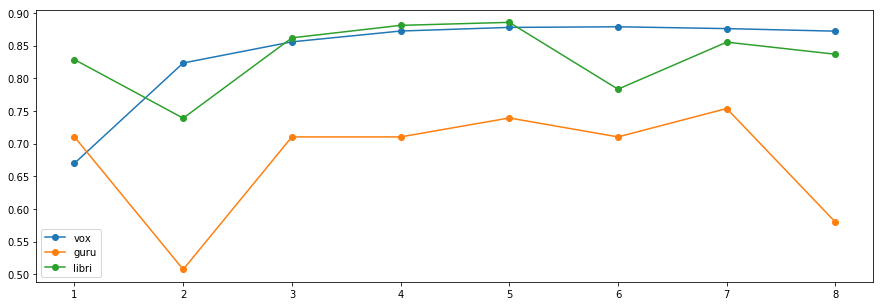

In [34]:
epochs = range(1, len(train_acc)+1)
plt.figure(figsize=(15, 5))
plt.plot(epochs, train_acc, 'o-', label='vox')
plt.plot(epochs, guru_acc, 'o-', label='guru')
plt.plot(epochs, libri_acc, 'o-', label='libri')
plt.legend()
plt.show()

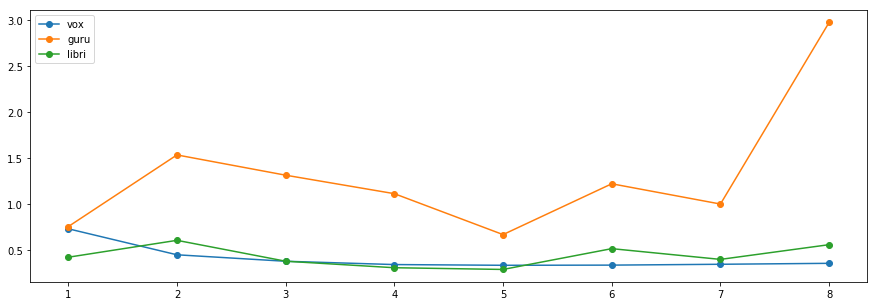

In [38]:
epochs = range(1, len(train_acc)+1)
plt.figure(figsize=(15, 5))
plt.plot(epochs, train_loss, 'o-', label='vox')
plt.plot(epochs, guru_loss, 'o-', label='guru')
plt.plot(epochs, libri_loss, 'o-', label='libri')
plt.legend()
plt.show()